In [1]:
import pandas as pd

In [2]:
recipesDF = pd.read_json('recipies.json')

In [3]:
recipesDF.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
recipesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [5]:
# drop empty entries
recipesDF = recipesDF[recipesDF['cuisine']!='']
recipesDF = recipesDF[recipesDF['ingredients'].apply(lambda d: len(d)) > 0]

In [6]:
recipesDF.head()
recipesDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
import matplotlib.pyplot as plt
recipesDF['cuisine'].value_counts().plot(kind='bar')
plt.ylabel('number of recipes')
plt.xlabel('cuisine')
#plt.savefig('cuisine1d.png',bbox_inches='tight')

Text(0.5, 0, 'cuisine')

In [8]:
# get a sense of all ingredients?
recipesDFExploded = recipesDF.explode('ingredients')


In [9]:
recipesDFExploded.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


In [10]:
#recipesDF.groupby(recipesDF['ingredients']).id.count().plot(kind='bar')

In [11]:
recipesDF['cuisine'].value_counts().min()

467

In [12]:
# need to clean the ingredients lists .. do i need nlp for this
for ingredients in recipesDF['ingredients']:
    #print(ingredients)
    for ingredient in ingredients:
        ingredient.lower()


In [13]:
recipesDF.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [14]:
recipesDFExploded = recipesDF.explode('ingredients')

In [15]:
recipesDFExploded.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


In [35]:
# first , don't do anything about the variance in ingredients. this will be our baseline.
# set up encoding so that all ingredients and cuisines are represented by a number
from sklearn.preprocessing import LabelEncoder
leX = LabelEncoder()
X_le = leX.fit_transform(recipesDFExploded['ingredients'])
leY = LabelEncoder()
y_le = leY.fit_transform(recipesDFExploded['cuisine'])

In [36]:
# split into train/ test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_le,y_le, test_size = 0.3, random_state = 0) 

In [37]:
# try looking at multi-word ingredients, these are prob the ones that need some editing
#recipesDFExploded['ingredients'].isin([' ']).groupby(recipesDFExploded['ingredients']).count().plot(kind='bar')

In [39]:
y_train

array([13,  2, 16, ...,  9,  7,  9])

In [42]:
# first try random forest
#from sklearn.linear_model import RandomForest
# I think this is sensitive to unbalanced datasets
# there is a way to weight the classes
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0,class_weight='balanced')
clf.fit(X_train.reshape(-1,1), y_train)




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
preds = clf.predict(X_test.reshape(-1,1))

In [45]:
pd.crosstab(y_test, preds, rownames=['Actual Cuisine'], colnames=['Predicted Cuisine'])
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,preds)

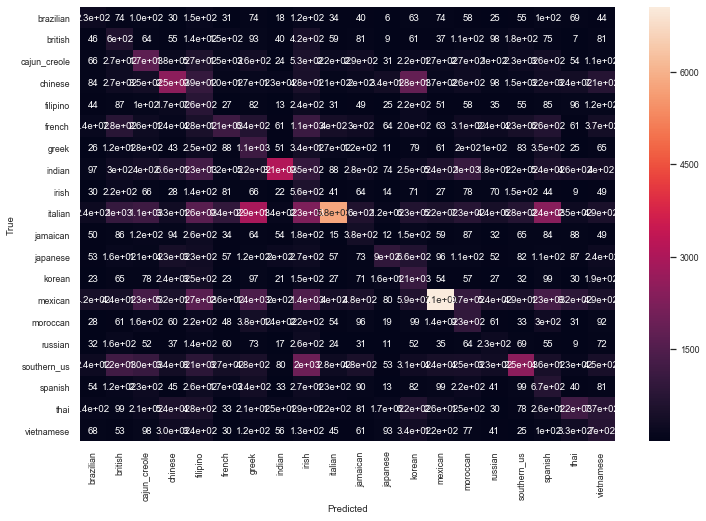

In [46]:

import seaborn as sns
df_cm = pd.DataFrame(cm, index = range(0,20),
                  columns = range(0,20))
plt.figure(figsize = (12,8))
sns.set(font_scale=0.8)

labels=leY.inverse_transform(range(0,20))

sns.heatmap(df_cm, annot=True,xticklabels=labels,yticklabels=labels)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show() # ta-da!
#plt.savefig('ConfusionMatrix_first.pdf')
plt.show()

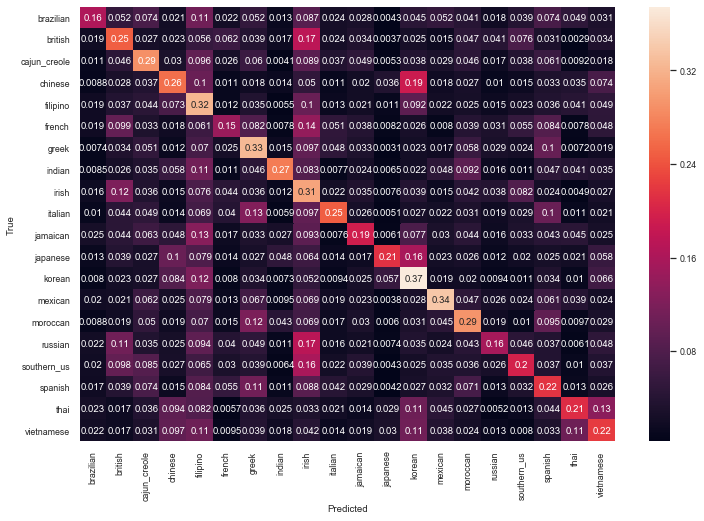

<Figure size 432x288 with 0 Axes>

In [66]:
df_cmN = df_cm.div(df_cm.sum(axis=1), axis=0)
       
plt.figure(figsize = (12,8))
sns.set(font_scale=0.8)
sns.heatmap(df_cmN, annot=True,xticklabels=labels,yticklabels=labels)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show() # ta-da!
plt.savefig('ConfusionMatrixNorm_explodedIngredients.pdf')
#plt.show()

In [85]:
# validation: 
# check recall 
# compare to random guess as baseline
from sklearn.metrics import recall_score
recall = recall_score(y_test,preds,average='micro')
recall

0.2583221126530358

In [86]:
# compare to random baseline
# take a random sample from y_le of length y_test
import numpy as np
rand = np.random.choice(y_le,len(y_test))
rand

array([ 2, 17, 13, ..., 16, 16,  9])

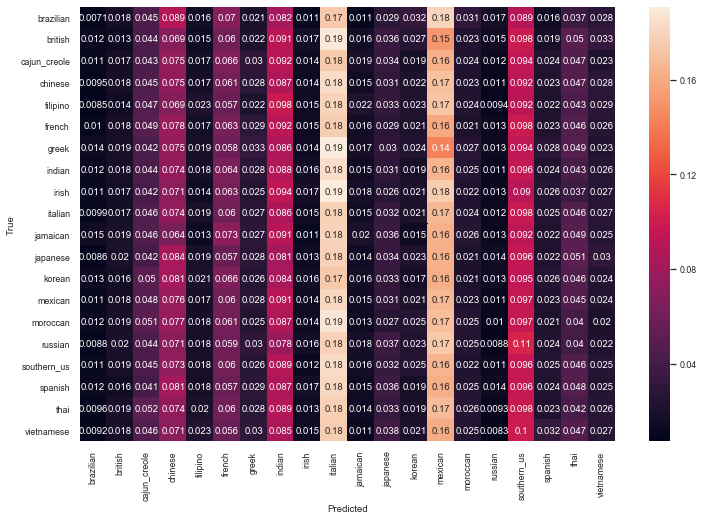

In [87]:
cmR = confusion_matrix(y_test,rand)
df_cmR = pd.DataFrame(cmR, index = range(0,20),
                  columns = range(0,20))
df_cmRN = df_cmR.div(df_cmR.sum(axis=1), axis=0)
       
plt.figure(figsize = (12,8))
sns.set(font_scale=0.8)
sns.heatmap(df_cmRN, annot=True,xticklabels=labels,yticklabels=labels)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.ylabel('True')
plt.xlabel('Predicted')
#plt.show() # ta-da!
plt.savefig('ConfusionMatrixNorm_recipes.png')
#plt.show()

In [88]:
recallR = recall_score(y_test,rand,average='micro')
recallR

0.0952110395927866

In [54]:


# now regroup by recipe ID
recipesDFDummy = pd.DataFrame(list(zip(recipesDFExploded.id,X_le,y_le)),columns=['id','ingredients','cuisine'])

In [55]:
recipesDFDummy.head()

,id,ingredients,cuisine
0,10259,5222,6
1,10259,956,6
2,10259,3033,6
3,10259,2884,6
4,10259,4569,6


In [64]:
# put back into list form, brute force 
ids,cuisines,ingredientss=[],[],[]
for iR,row in recipesDFExploded.iterrows():
    if row.id not in ids:
        ids.append(row.id)
        cuisines.append(leY.transform([row.cuisine])[0])
        ingredientss.append([leX.transform([row.ingredients])[0]])
    else:
        idx = ids.index(row.id)
        ingredientss[idx].append(leX.transform([row.ingredients])[0])
recipesDFCollapsed = pd.DataFrame(list(zip(ids,cuisines,ingredientss)),columns=['id','ingredients','cuisine'])

In [65]:
recipesDFCollapsed.head()

,id,ingredients,cuisine
0,10259,6,"[5222, 956, 3033, 2884, 4569, 4911, 5405, 2878..."
1,25693,16,"[4709, 3166, 5309, 6146, 3135, 6090, 2436, 311..."
2,20130,4,"[2436, 4569, 5309, 4031, 1940, 3090, 3124, 290..."
3,22213,7,"[6435, 6375, 6450, 5309]"
4,13162,7,"[958, 5451, 1978, 1415, 4361, 2899, 4108, 1220..."


In [67]:
recipesDFCollapsed = pd.DataFrame(list(zip(ids,cuisines,ingredientss)),columns=['id','cuisine','ingredients'])
recipesDFCollapsed.head()

,id,cuisine,ingredients
0,10259,6,"[5222, 956, 3033, 2884, 4569, 4911, 5405, 2878..."
1,25693,16,"[4709, 3166, 5309, 6146, 3135, 6090, 2436, 311..."
2,20130,4,"[2436, 4569, 5309, 4031, 1940, 3090, 3124, 290..."
3,22213,7,"[6435, 6375, 6450, 5309]"
4,13162,7,"[958, 5451, 1978, 1415, 4361, 2899, 4108, 1220..."


In [77]:
from sklearn.preprocessing import MultiLabelBinarizer
MLB = MultiLabelBinarizer()
df_2 = pd.DataFrame(MLB.fit_transform(recipesDFCollapsed['ingredients']), columns=MLB.classes_)
df_2




,0,1,2,3,4,5,6,7,8,9,...,6704,6705,6706,6707,6708,6709,6710,6711,6712,6713
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
rdfcoh = pd.concat([df_2, recipesDFCollapsed.drop('ingredients',1)],1)



In [79]:
X_trainC, X_testC, y_trainC, y_testC = train_test_split(rdfcoh.drop(columns=['cuisine']),rdfcoh['cuisine'], test_size = 0.3, random_state = 0) 


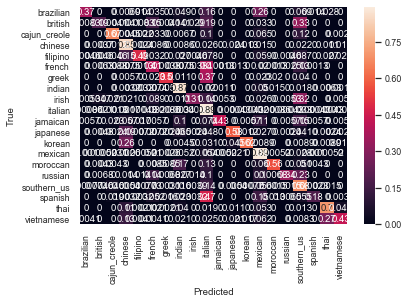

In [80]:

clfC = RandomForestClassifier(random_state=0,class_weight='balanced')
clfC.fit(X_trainC, y_trainC)

predsC = clfC.predict(X_testC)
cmC = confusion_matrix(y_testC,predsC)

df_cmC = pd.DataFrame(cmC, index = range(0,20),
                      columns = range(0,20))

df_cmCN = df_cmC.div(df_cmC.sum(axis=1), axis=0)




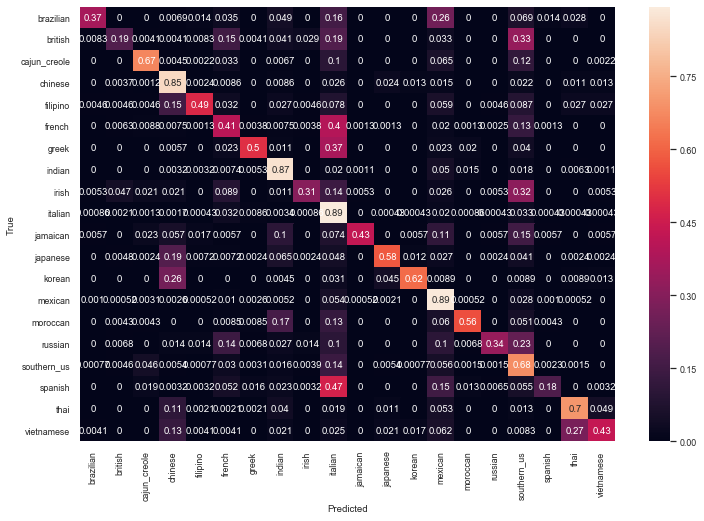

In [82]:
plt.figure(figsize = (12,8))
sns.set(font_scale=0.8)
sns.heatmap(df_cmCN, annot=True,xticklabels=labels,yticklabels=labels)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig('ConfusionMatrixNorm_oneHot.png')
plt.show() # ta-da!
#

In [83]:
# validation: 
# check recall 
# compare to random guess as baseline

recall = recall_score(y_testC,predsC,average='micro')
recall

0.7035112712645605

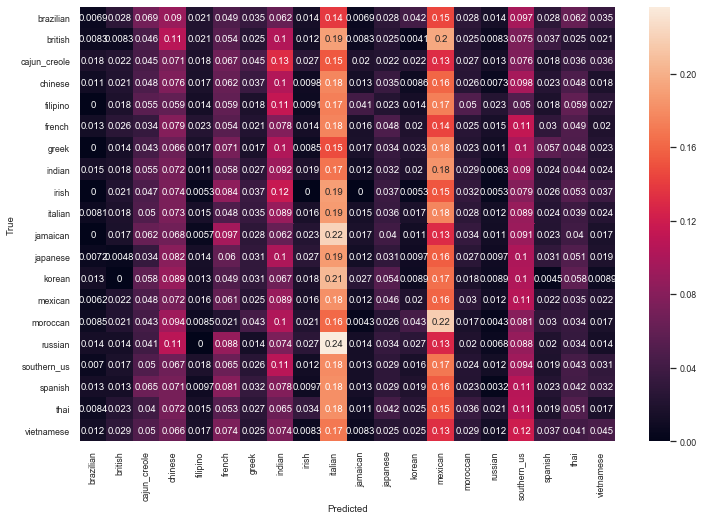

In [81]:
# compare to random baseline
# take a random sample from y_le of length y_test
import numpy as np
rand = np.random.choice(y_le,len(y_testC))
cmCR = confusion_matrix(y_testC,rand)
df_cmCR = pd.DataFrame(cmCR, index = range(0,20),
                  columns = range(0,20))
df_cmCRN = df_cmCR.div(df_cmCR.sum(axis=1), axis=0)
       
plt.figure(figsize = (12,8))
sns.set(font_scale=0.8)
sns.heatmap(df_cmCRN, annot=True,xticklabels=labels,yticklabels=labels)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.ylabel('True')
plt.xlabel('Predicted')
#plt.show() # ta-da!
plt.savefig('ConfusionMatrixNorm_oneHot_random.png')
#plt.show()

In [84]:
recallR = recall_score(y_testC,rand,average='micro')
recallR

0.0968742143635297